status : Add Reg to Deep - L - Layer model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from nn_utils import sigmoid, ReLU, dsigmoid, dReLU
from nn_utils import binary_cross_entropy, update_param, cut_off_threshold

---

In [2]:
"""
Initiate parameter
"""


def initiate_param(layer_dims,initialization = 'random',seed:int=42):
    """Initiate the paramaters W, B for each layer
    
    Arguments
    ----------
        layer_dims : list
            A sequence of number of units for every layer 
        initialization : str, optional
            A technique of weight initialization (default:random)
        seed : int, optional 
            A seed for randomize the initialization
        
    
    Returns
    ----------
        param : numpy.array
            Array of parameter of every layer 
    
    """
    if seed:
        np.random.seed(seed)
    
    # 4 Options of weight initializating
    if initialization == 'zero':
        param = initialization_zero(layer_dims)
    elif initialization == 'random':
        param = initialization_random(layer_dims)
    elif initialization == 'He':
        param = initialization_he(layer_dims)
    elif initialization == 'Xavier':    
        param = initialization_xavier(layer_dims)
    else: #default : random
        print(f'''There is no weight initialization called "{initialization}"
              switch to default initialization random
              ''')
        param = initialization_random(layer_dims)
        
    return param


In [3]:
def initialization_zero(layer_dims:list):
    """Initialize both weight and bias as zeros
    
    Arguments
    ----------
    layer_dims : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        param["W" + str(l)] = np.zeros(shape=(layer_dims[l], layer_dims[l-1])) * 0.01 # Uniform(0,1] * 0.01
        param["b" + str(l)] = np.zeros(shape=(layer_dims[l], 1))
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [4]:
def initialization_random(layer_dims:list,scale:int=0.01):
    
    """Initialize weight randomly with Normal(mean=0,sigma=1)
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    scale : float, optional
        A constant to scale the weight initialization
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    """
    scale : variance of the random variable
    y = scale * x
    var(y) = var(scale*x)
    var(y) = scale^2 * x
    """
    for l in range(1,L+1):
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * scale # Normal(0,1) * scale 
        param["b" + str(l)] = np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [5]:
def initialization_xavier(layer_dims:list):
    """
    Initialize weight randomly with Normal(mean=0,sigma=(1/fan_avg))
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        fan_in , fan_out = layer_dims[l-1] , layer_dims[l]
        fan_avg = 1/2 * (fan_in + fan_out)
        
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1/fan_avg) 
        param["b" + str(l)] =  np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [6]:
def initialization_he(layer_dims:list):
    """
    Initialize weight randomly with Normal(mean=0,sigma=(2/fan_in))
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        fan_in = layer_dims[l-1]
        
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/fan_in) 
        param["b" + str(l)] =  np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [7]:
"""
Forward Propagation Unit
"""


def linear_forward(A_prev, W, b):
    """Linear Forward unit
    
    Argument
    ----------    
    1. A_prev --- Activation node of the previous layer A[l-1]
    2. W --- Weight of layer l
    3. b --- Bias of layer l

    Return
    ----------
    1. Z --- Output Z of layer l 
    2. caches --- cache of Linear forward Unit
    """
    Z = np.dot(W, A_prev) + b
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev,W,b)      # A :for dZ, W for dA & to get updating, b for updating , dA for dZ
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_function):
    """Linear Forward unit
    
    Argument
    ----------    
    1. A_prev --- Activation node of the previous layer A[l-1]
    2. W --- Weight of layer l
    3. b --- Bias of layer l

    Return
    ----------
    1. Z --- Output Z of layer l 
    2. caches --- cache of Linear forward Unit and Activation function
    """
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation_function == "sigmoid":
        A = sigmoid(Z)
    elif activation_function == "tanh":
        A = tanh(Z)
    elif activation_function == "ReLU":
        A = ReLU(Z)
    elif activation_function == "LeakyReLU":
        A = LeakyReLU(Z)
    elif activation_function == "linear":
        A = Z
    
    activation_cache = Z
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (activation_cache, linear_cache)  # (Z, (A_prev,W,b))

    return A, cache


def L_model_forward(X, param, activation_function="ReLU", last_activation_function="sigmoid"):
    """Forward propagation model from input to output layer
       Apply parameter to the input X to return the Activation Output 
    
    Argument
    ----------    
    1. X --- Input denoted as A[0]
    2. param --- Weight and Bias of every layer
    3. activation_function --- the activation function for hidden layer (default:ReLU)
    4. last_activation_function --- the activation function for output layer (default:sigmoid)
                                    Classication : sigmoid
                                    Regression : linear

    Return
    ----------
    1. AL --- Output A[L] from the propagation (Z[L] with sigmoid activation function)
    2. caches --- the cache of every layer l 
    """

    A = X
    L = (len(param) // 2)  # param stores the weight and bias for L layer, hence len(param) = 2L

    caches = []
    
    # For Hidden Layer [1,2..,L-1]
    for l in range(1,L):  # l = 1,2,..,L-1
        A_prev = A
        W = param["W" + str(l)]
        b = param["b" + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, activation_function)
        caches.append(cache)  # append cache at layer l
    
    # For Output layer [L]

    A_prev = A
    W = param["W" + str(L)]
    b = param["b" + str(L)]
    AL, cache = linear_activation_forward(A_prev, W, b, last_activation_function)
    caches.append(cache)

    
    assert(AL.shape == (1, X.shape[1]))

    return AL, caches


In [8]:
def compute_cost(AL, Y):
    """
    Compute the cost function with respect to tAL
    cost function : Binary cross entropy
    Arguments:
    A --- predicted value from L-Forward model
    y --- actual output
    """
    
    m = Y.shape[1]
    
    loss = binary_cross_entropy(AL, Y)
    cost = np.divide(loss, m)  # No significant difference in speed when compare to '/' though
    cost = np.sum(cost, axis=1)
    
    return cost

In [9]:
"""
Backward Propagation Unit
"""


def linear_backward(dZ, cache):
    """Use dZ from the layer l to obtain dW,dB,dA_prev
    Arguments
    ----------
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (Z,(A_prev, W, b)) coming from the forward propagation in the current layer (We use only linear cache anyway)

    Returns
    ----------
      dA_prev --- Gradient of the cost with respect to the activation node at the previous layer
      dW --- Gradient of the cost with the weight in this layer
      db --- Gradient of the cost with the bias in this layer
    """
    _, linear_cache = cache  # We use only linear cache
    (A_prev, W, b) = linear_cache  # We do not use b to obtain those 3 gradients

    m = dZ.shape[1]  

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_function):
    """Input dA to find dZ, then use dZ to obtain dW,dB,dA_prev
    Arguments
    ----------
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (Z,(A_prev, W, b)) coming from the forward propagation in the current layer (We use only linear cache anyway)
    
    Returns
    ----------
      dA_prev --- Gradient of the cost with respect to the activation node at the previous layer
      dW --- Gradient of the cost with the weight in this layer
      db --- Gradient of the cost with the bias in this layer
    """
    if activation_function == "ReLU":
        g_ = dReLU
    elif activation_function == "LeakyReLU":
        g_ = dLeakyReLU
    elif activation_function == "tanh":
        g_ = dTanh
    elif activation_function == "sigmoid":
        g_ = dsigmoid
    else:
        print(f"The activation function {activation_function} not found, ReLU as default")
        g_ = dReLU

    activation_cache, _ = cache  # We use only activation cache
    Z = activation_cache

    dZ = dA * g_(Z)
    dA_prev, dW, db = linear_backward(dZ, cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, cache, activation_function="ReLU", last_activation_function="sigmoid"):
    """
    Backward propagation model from output AL to the parameter gradient of all layers
    Apply parameter to the input X to return the Activation Output 
    
    Arguments:
    A --- A at the layer L
    y --- an actual output
    cache --- cache from the forward propagation
    activation_function --- activation function for the hidden layer
    Return:
     grads  -- A dictionary with the gradients
               grads["dA" + str(l)] = ...
               grads["dW" + str(l)] = ...
               grads["db" + str(l)] = ...
    """
    L = len(cache)  # cache for each layer
    grads = {}
    
    # For Output layer
    dAL = np.divide(1 - Y, 1 - AL) - np.divide(Y, AL)  # dA_[L] : Input for the first linear activation backward
                                                    # Loss : Binary Cross Entropy
    
    current_cache = cache[-1] 
    dA_prev, dW, db = linear_activation_backward(dAL,current_cache,last_activation_function)
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    dA = dA_prev
    
    
    # For Hidden layer [L-1, L-2...,1]
    for l in reversed(range(1,L)): 

        current_cache = cache[l-1] 
        (activation_cache, linear_cache) = current_cache
        
        Z = activation_cache
        a_prev, W, b = linear_cache  # Start with Z_[L] , A_[L-1], W_[L], b_[L]
        
        dA_prev, dW, db = linear_activation_backward(dA, current_cache, activation_function)

        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
        
        dA = dA_prev

    return grads

In [10]:
def update_param(param, grads, lr=1e-4):
    """Update parameter 
    Argument:
    1. param -- The current parameter (W1,W2,...,WL,b1,b2,...bL)
    2. grads -- the dictionary of gradient that was obtained from L_model_backward function
    3. lr (default=1e-4) : Learning rate
    Returns:
    1. updated_param -- The parameter that got updated
    """

    L = len(param) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1,L+1):
        param["W" + str(l)] = (param["W" + str(l)] - lr * grads["dW" + str(l)])
        param["b" + str(l)] = (param["b" + str(l)] - lr * grads["db" + str(l)])

    return param


In [11]:
a = np.array([[0.99,0.4,0.3]])
b = np.array([[1,1,1]])

compute_cost(a,b)

array([0.71010462])

In [12]:
class Binary_Deep_L_Layer:
    """
    A Deep neural network with L layers
    - Able to fit with the predictors (X) and the response (Y)
    - Able to predict_proba and predict with threshold
    To see the last fit model parameter, uses self.param where self refer to the fit model
    """

    def __init__(self, hyperparam: dict):
        """
        Launch the Deep_L_layer with the given hyperparameter
        
        Arguments:
        hyperparam: A dictionary with key:
         L --- Number of Layers (Hidden layer(s) + Output layer)
         layer_dims --- Number of units of that L layer
         lr --- Learning rate
         forward_activation_function --- Activation function for all hidden layer(s) in forward model (ReLU,LeakyReLU,tanh,sigmoid)
         last_forward_activation_function --- Activation function for all hidden layer(s) in forward model (sigmoid,linear)
          {"L" : 5,
          "layer_dims" : [nrow,8,6,4,2,1],
          "lr" : 1e-5,
          "forward_activation_function" : 'tanh' ,
          "last_forward_activation_function" : 'sigmoid' }
          
        Supported activation
        """
        self.hyperparam = hyperparam  # assume include nrow in dict

        # Explicit hyperparameter attributes
        self.L = hyperparam["L"]
        self.lr = hyperparam["lr"]
        self.forward_activation_function = hyperparam["forward_activation_function"]
        self.last_forward_activation_function = hyperparam["last_forward_activation_function"]
        
    def compiles(self, initialization = 'random' , optimizer='adam', loss='binary_cross_entropy'):
        """
        Develop soon (optional hyperparameter)
        """
        self.initialization = initialization
        self.optimizer = optimizer
        self.loss = loss
        
    def fit(
        self,
        X: pd.DataFrame,
        Y: pd.Series,
        Epochs: int = 1000,
        report_cost: bool = True,
        warmup: bool = False,
    ):
        """
        Fit the launched Deep L layer with the given data X , Y

        Arguments:
         X --- Pandas Dataframe of predictors
         Y --- Pandas Series of response (0 : negative, 1:positive)
         Epoch --- number of epochs (default : 1000)
         report_cost --- report the cost epochs every 1000 epoch
         warmup --- update param and save the parameter
        """

        ## First, we initiate the attributes

        # We turn Dataframe into Numpy format
        X = X.to_numpy().T
        Y = Y.to_numpy().T
        nrow = np.shape(X)[0]

        # Assign class attribute
        self.X = X
        self.Y = Y
        self.m = Y.shape[1]
        self.Epochs = Epochs

        self.param = initiate_param(layer_dims = self.hyperparam['layer_dims'],
                                        initialization = self.initialization)
        
        for epoch in range(self.Epochs +1):
            A, cache = L_model_forward(self.X, self.param, 
                                       activation_function=self.forward_activation_function,
                                      last_activation_function=self.last_forward_activation_function)
            #print(A)
            if (report_cost and epoch % 1000 == 0):
                cost = compute_cost(A, self.Y)
                print(f"Epoch {epoch}/{Epochs} : ===Cost=== : {np.squeeze(cost)}")

            grads = L_model_backward(A, self.Y, cache, 
                                     self.forward_activation_function,
                                    self.last_forward_activation_function)
            
            self.param = update_param(self.param, grads, lr=self.lr)
            
    def predict_proba(self, X: pd.DataFrame):
        """
        Predict probability of the observation given input X

        Arguments:
         X --- Pandas Dataframe or Series of predictors
        """
        X = X.to_numpy().T

        A_prob, _ = L_model_forward(X, self.param, 
                                    activation_function=self.forward_activation_function,
                                    last_activation_function=self.last_forward_activation_function
                                   )

        return A_prob

    def predict(self, X, threshold: float = 0.5,predict_proba=False):
        """
        Predict the observation given input X

        Arguments:
         X --- Pandas Dataframe or Series of predictors
        """
        
        A_prob, _ = L_model_forward(X, self.param, 
                            activation_function=self.forward_activation_function,
                            last_activation_function=self.last_forward_activation_function
                           )
        
        
        if not predict_proba:
            A_pred = cut_off_threshold(A_prob, threshold)
        else:
            A_pred = A_prob
        return A_pred

    def __repr__(self):
        return f"Deep_L_Layer({self.hyperparam})"

    def __str__(self):
        return f"A Deep {self.L} Neural network with learning rate = {self.lr} (Forward activation :{self.forward_activation_function},Backward activation :{self.backward_activation_function})"




---



Test case

In [13]:
from import_dataset import load_2D_dataset,load_2D_dataset_pandas

In [14]:
# Hyperparameter


hyperparam = {"L" : 5,
              "layer_dims" : [2,8,6,4,2,1],
              "lr" : 1e-4,
              "forward_activation_function" : 'ReLU',
              "last_forward_activation_function" : 'sigmoid',
              "keep_prob_sequence" : [1,0.5,0.6,0.7,1,1]}   #Dropout => No dropout = None OR [1,1,1,1,1,1]


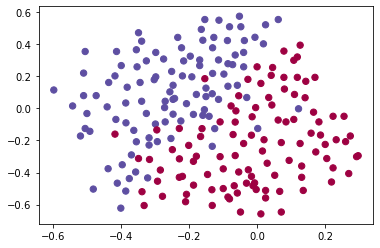

In [15]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

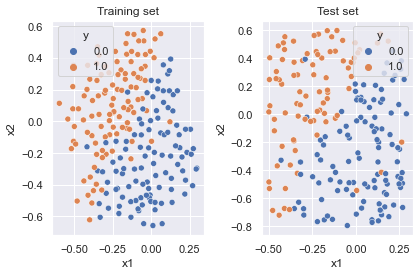

In [18]:
df_train, df_test = load_2D_dataset_pandas(train_X, train_Y, test_X, test_Y)

Fit

In [16]:
model = Binary_Deep_L_Layer(hyperparam)
model.compiles(initialization ='He')
model.fit(X,Y,Epochs=100000)

Accuracy

In [ ]:
Y_pred = model.predict(X)
y = Y.values.T

In [ ]:
arr = y - Y_pred

In [ ]:
#Accuracy
np.count_nonzero(arr==0) / len(Y)

In [ ]:
plt.title("Model with He initialization")
axes = plt.gca()
plot_decision_boundary(lambda x: predict_dec(model.param, x.T), X.values, Y.values)

In [ ]:
model.predict(pd.DataFrame(np.array([[0,0.7]])))